In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
SEED=3093453
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [2]:


df = pd.DataFrame(columns = ["Set", "Filename", "raw"])


for Set in ["A", "B", "C", "X"]:
#for Set in ["X"]:
    path = os.path.join(cwd, "data", Set)
    for dirpath, dirnames, filenames in os.walk(path):
        filenames = sorted(filenames)
        for filename in filenames:
            if not filename.endswith(".out"):
                continue
            filepath = os.path.join(dirpath, filename)
            #print(filename)
            with open(filepath, "r") as f:
                raw_text = f.read()
            
            data = pd.DataFrame([[Set, filename[:-4], raw_text]], columns = ["Set", "Filename", "raw"])
            df = pd.concat([df, data])


#df = df[df.Filename.str.contains(r"[A-Z][A-Z]\d?\-\d{1,3}")]

df["Threshold"] = df["Filename"].str.extract("\-(\d*)").astype(float)
df["Instance"] = df["Filename"].str.split("-").str[0]
df = df.sort_values(["Set", "Filename"]).reset_index(drop=True)
df

,Set,Filename,raw,Threshold,Instance
0,A,AS,"cpu-bind=MASK - cn-0156, task 0 0 [3982125]:...",NaN,AS
1,A,AS-0,"cpu-bind=MASK - cn-0248, task 0 0 [858429]: ...",0.0,AS
2,A,AS-10,"cpu-bind=MASK - cn-0226, task 0 0 [1783353]:...",10.0,AS
3,A,AS-100,"cpu-bind=MASK - cn-0077, task 0 0 [462554]: ...",100.0,AS
4,A,AS-20,"cpu-bind=MASK - cn-0248, task 0 0 [858854]: ...",20.0,AS
...,...,...,...,...,...
2676,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90.0,VA7
2677,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90.0,VA7
2678,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90.0,VA7
2679,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90.0,VA7


In [3]:
df["finalObjective"] = df.raw.str.extract("Final Solution\nObjective;(\d*\.?\d?)\nTransportation cost;").astype(float)
df["finalTransportationCost"] = df.raw.str.extract("Final Solution\nObjective;\d*\.?\d?\nTransportation cost;(\d*\.?\d?)").astype(float)
df["finalInventoryCost"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;(\d*\.?\d?)"
).astype(float)
df["Runtime"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;\d*\.?\d?\nRuntime;(\d*\.?\d?)"
).astype(float)
#df["finalObjective"].hist()

In [4]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()

In [5]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()
#num_LNS_iterations.index.name=
num_LNS_iterations.name = "num_LNS_iter"
df = df.join(num_LNS_iterations)
df["num_LNS_iter"] = df["num_LNS_iter"].fillna(0).astype(int)

In [6]:
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,A,AS,"cpu-bind=MASK - cn-0156, task 0 0 [3982125]:...",NaN,AS,394590.0,377100.0,17490.0,109.1,0
1,A,AS-0,"cpu-bind=MASK - cn-0248, task 0 0 [858429]: ...",0.0,AS,394590.0,377100.0,17490.0,109.3,0
2,A,AS-10,"cpu-bind=MASK - cn-0226, task 0 0 [1783353]:...",10.0,AS,394590.0,375600.0,18990.0,348.6,0
3,A,AS-100,"cpu-bind=MASK - cn-0077, task 0 0 [462554]: ...",100.0,AS,394590.0,377100.0,17490.0,348.1,0
4,A,AS-20,"cpu-bind=MASK - cn-0248, task 0 0 [858854]: ...",20.0,AS,394590.0,377100.0,17490.0,349.5,0
...,...,...,...,...,...,...,...,...,...,...
2676,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90.0,VA7,29109.0,24000.0,5109.0,6.0,0
2677,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90.0,VA7,29109.0,24000.0,5109.0,6.3,0
2678,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90.0,VA7,29109.0,24000.0,5109.0,6.3,0
2679,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90.0,VA7,29109.0,24000.0,5109.0,5.9,0


In [7]:
reference_df = df[df.Threshold.isnull()].copy()
df = df[~df.Threshold.isnull()].copy().reset_index(drop=True)
df["Threshold"] = df["Threshold"].astype(int)
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,A,AS-0,"cpu-bind=MASK - cn-0248, task 0 0 [858429]: ...",0,AS,394590.0,377100.0,17490.0,109.3,0
1,A,AS-10,"cpu-bind=MASK - cn-0226, task 0 0 [1783353]:...",10,AS,394590.0,375600.0,18990.0,348.6,0
2,A,AS-100,"cpu-bind=MASK - cn-0077, task 0 0 [462554]: ...",100,AS,394590.0,377100.0,17490.0,348.1,0
3,A,AS-20,"cpu-bind=MASK - cn-0248, task 0 0 [858854]: ...",20,AS,394590.0,377100.0,17490.0,349.5,0
4,A,AS-30,"cpu-bind=MASK - cn-0179, task 0 0 [2049666]:...",30,AS,394590.0,377100.0,17490.0,349.7,0
...,...,...,...,...,...,...,...,...,...,...
2451,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90,VA7,29109.0,24000.0,5109.0,6.0,0
2452,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0
2453,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0
2454,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90,VA7,29109.0,24000.0,5109.0,5.9,0


In [8]:
reference_df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,A,AS,"cpu-bind=MASK - cn-0156, task 0 0 [3982125]:...",NaN,AS,394590.0,377100.0,17490.0,109.1,0
12,A,BU,"cpu-bind=MASK - cn-0161, task 0 0 [1649876]:...",NaN,BU,484590.0,450000.0,34590.0,682.2,6
24,A,BY,"cpu-bind=MASK - cn-0163, task 0 0 [1523893]:...",NaN,BY,3166410.0,2925300.0,241110.0,1677.8,5
36,A,BY2,"cpu-bind=MASK - cn-0153, task 0 0 [3694220]:...",NaN,BY2,3491520.0,3251250.0,240270.0,1539.9,9
48,A,CA,"cpu-bind=MASK - cn-0080, task 0 0 [3561355]:...",NaN,CA,759980.0,748800.0,11180.0,102.4,1
...,...,...,...,...,...,...,...,...,...,...
2623,X,VA3,"cpu-bind=MASK - cn-0014, task 0 0 [1643472]:...",NaN,VA3,120032.0,105000.0,15032.0,29.6,0
2635,X,VA4,"cpu-bind=MASK - cn-0049, task 0 0 [1727902]:...",NaN,VA4,29709.0,24600.0,5109.0,6.4,0
2647,X,VA5,"cpu-bind=MASK - cn-0056, task 0 0 [3451343]:...",NaN,VA5,36755.0,32100.0,4655.0,4.7,0
2659,X,VA6,"cpu-bind=MASK - cn-0129, task 0 0 [110430]: ...",NaN,VA6,119026.0,106500.0,12526.0,7.9,0


In [9]:
df = df.merge(
    reference_df[["Set", "Instance", "finalTransportationCost", "finalInventoryCost", "finalObjective", "Runtime", "num_LNS_iter"]],
    how="left",
    on=["Set", "Instance"],
    suffixes=("", "_Reference"),
    
)
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference
0,A,AS-0,"cpu-bind=MASK - cn-0248, task 0 0 [858429]: ...",0,AS,394590.0,377100.0,17490.0,109.3,0,377100.0,17490.0,394590.0,109.1,0.0
1,A,AS-10,"cpu-bind=MASK - cn-0226, task 0 0 [1783353]:...",10,AS,394590.0,375600.0,18990.0,348.6,0,377100.0,17490.0,394590.0,109.1,0.0
2,A,AS-100,"cpu-bind=MASK - cn-0077, task 0 0 [462554]: ...",100,AS,394590.0,377100.0,17490.0,348.1,0,377100.0,17490.0,394590.0,109.1,0.0
3,A,AS-20,"cpu-bind=MASK - cn-0248, task 0 0 [858854]: ...",20,AS,394590.0,377100.0,17490.0,349.5,0,377100.0,17490.0,394590.0,109.1,0.0
4,A,AS-30,"cpu-bind=MASK - cn-0179, task 0 0 [2049666]:...",30,AS,394590.0,377100.0,17490.0,349.7,0,377100.0,17490.0,394590.0,109.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90,VA7,29109.0,24000.0,5109.0,6.0,0,24000.0,5109.0,29109.0,6.4,0.0
2452,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0,24000.0,5109.0,29109.0,6.4,0.0
2453,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0,24000.0,5109.0,29109.0,6.4,0.0
2454,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90,VA7,29109.0,24000.0,5109.0,5.9,0,24000.0,5109.0,29109.0,6.4,0.0


In [10]:
df["Subset"] = "Training"
df.loc[(df.Set == "X") & (df.Instance.str.endswith("4") | df.Instance.str.endswith("5")), "Subset"] = "Validation"
df.loc[(df.Set == "X") & (df.Instance.str.endswith("6") | df.Instance.str.endswith("7")), "Subset"] = "Testing"

In [11]:
df = df[(df["Subset"] == "Training")]

In [12]:
clms = df.columns

for clm in clms[clms.str.contains("_Reference")]:
    clm_clean = clm.split("_Reference")[0]
    df[clm_clean] = df[clm_clean] / df[clm]

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_68327/2554790196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clm_clean] = df[clm_clean] / df[clm]


In [13]:
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference,Subset
0,A,AS-0,"cpu-bind=MASK - cn-0248, task 0 0 [858429]: ...",0,AS,1.0,1.000000,1.000000,1.001833,NaN,377100.0,17490.0,394590.0,109.1,0.0,Training
1,A,AS-10,"cpu-bind=MASK - cn-0226, task 0 0 [1783353]:...",10,AS,1.0,0.996022,1.085763,3.195234,NaN,377100.0,17490.0,394590.0,109.1,0.0,Training
2,A,AS-100,"cpu-bind=MASK - cn-0077, task 0 0 [462554]: ...",100,AS,1.0,1.000000,1.000000,3.190651,NaN,377100.0,17490.0,394590.0,109.1,0.0,Training
3,A,AS-20,"cpu-bind=MASK - cn-0248, task 0 0 [858854]: ...",20,AS,1.0,1.000000,1.000000,3.203483,NaN,377100.0,17490.0,394590.0,109.1,0.0,Training
4,A,AS-30,"cpu-bind=MASK - cn-0179, task 0 0 [2049666]:...",30,AS,1.0,1.000000,1.000000,3.205316,NaN,377100.0,17490.0,394590.0,109.1,0.0,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,X,VA3-50,"cpu-bind=MASK - cn-0079, task 0 0 [770344]: ...",50,VA3,1.0,1.000000,1.000000,5.766892,NaN,105000.0,15032.0,120032.0,29.6,0.0,Training
2410,X,VA3-60,"cpu-bind=MASK - cn-0193, task 0 0 [700142]: ...",60,VA3,1.0,1.000000,1.000000,5.777027,NaN,105000.0,15032.0,120032.0,29.6,0.0,Training
2411,X,VA3-70,"cpu-bind=MASK - cn-0235, task 0 0 [1591975]:...",70,VA3,1.0,1.000000,1.000000,5.777027,NaN,105000.0,15032.0,120032.0,29.6,0.0,Training
2412,X,VA3-80,"cpu-bind=MASK - cn-0011, task 0 0 [748394]: ...",80,VA3,1.0,1.000000,1.000000,0.706081,NaN,105000.0,15032.0,120032.0,29.6,0.0,Training


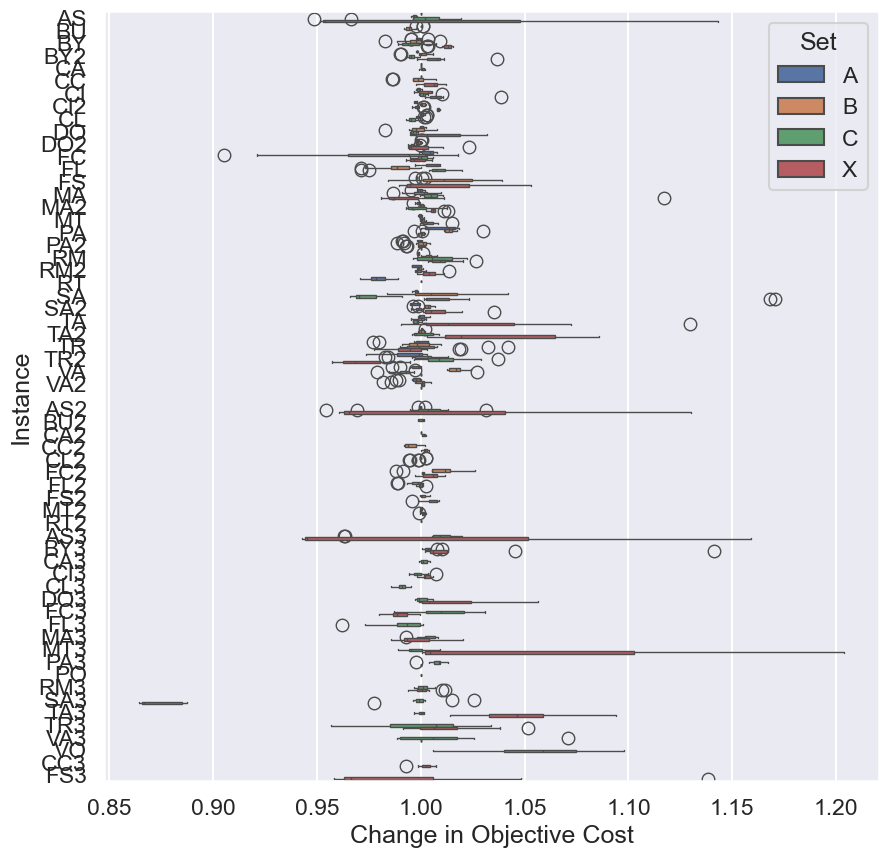

In [14]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

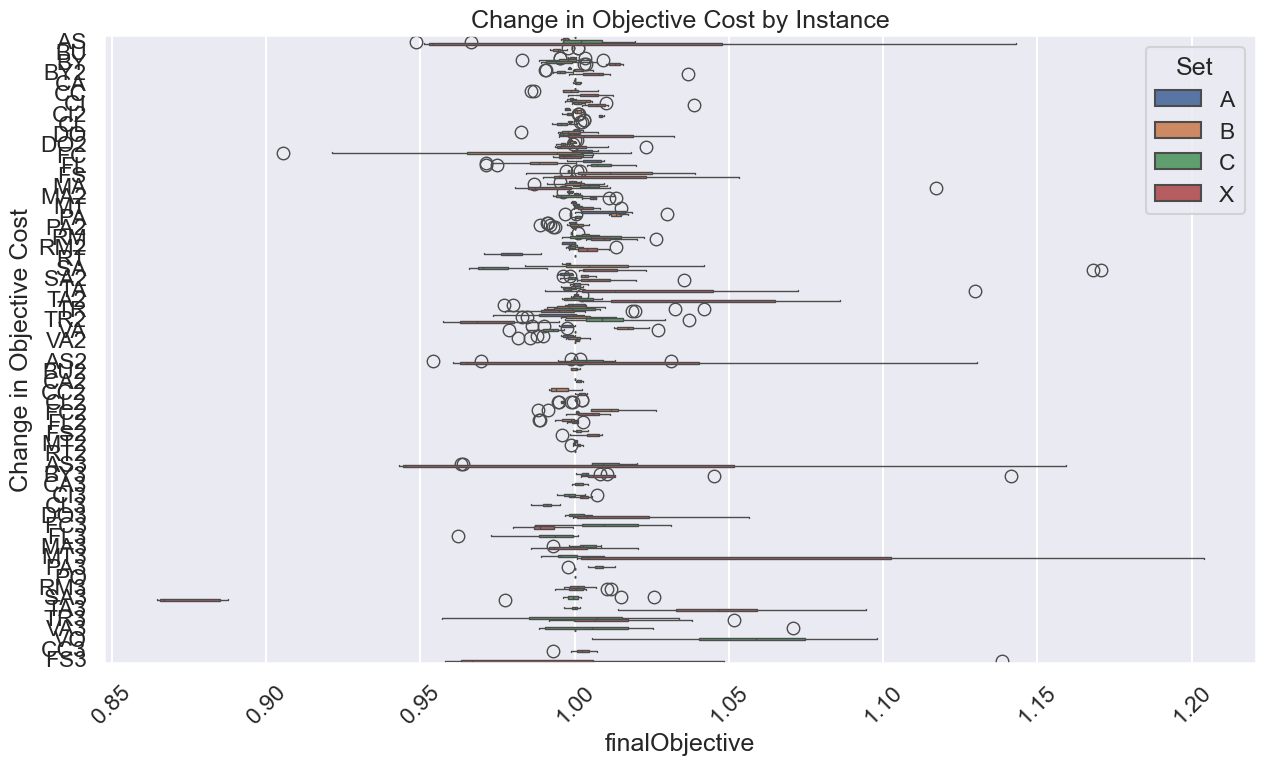

In [15]:
plt.figure(figsize=(13, 8))
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
#sns.boxplot(data=df, x="Instance", y="finalObjective", hue="Subset");
plt.ylabel("Change in Objective Cost");
plt.title("Change in Objective Cost by Instance");
plt.xticks(rotation=45);

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold-Training", f"Change in Objective by Instance TRAINING.{file_format}")
    plt.savefig(path)


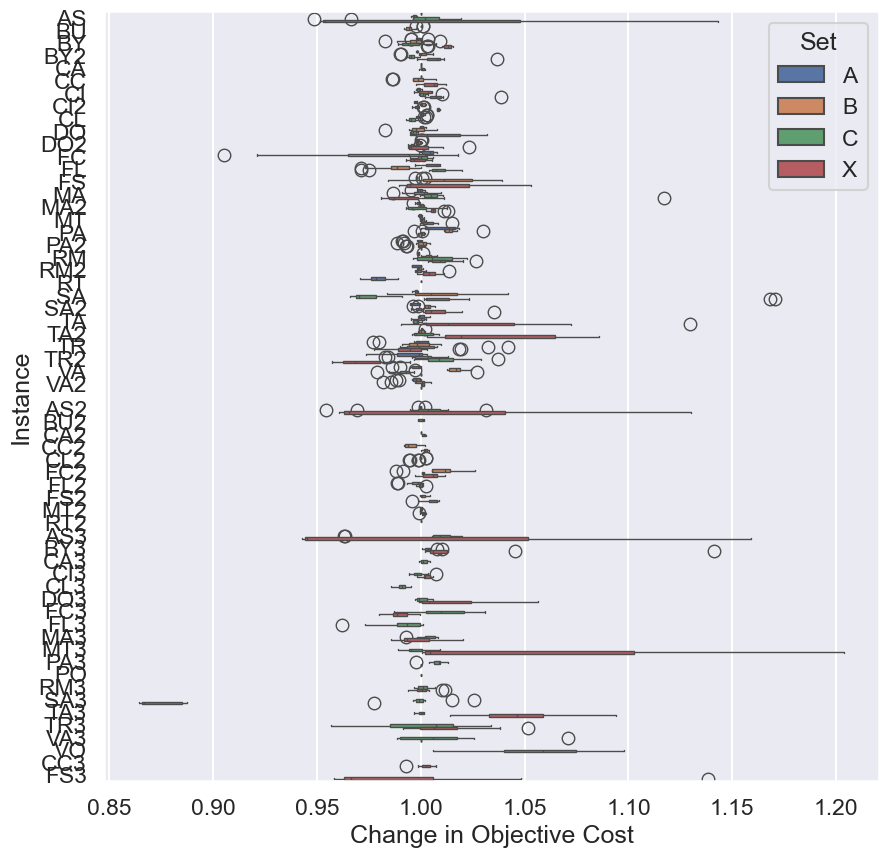

In [16]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

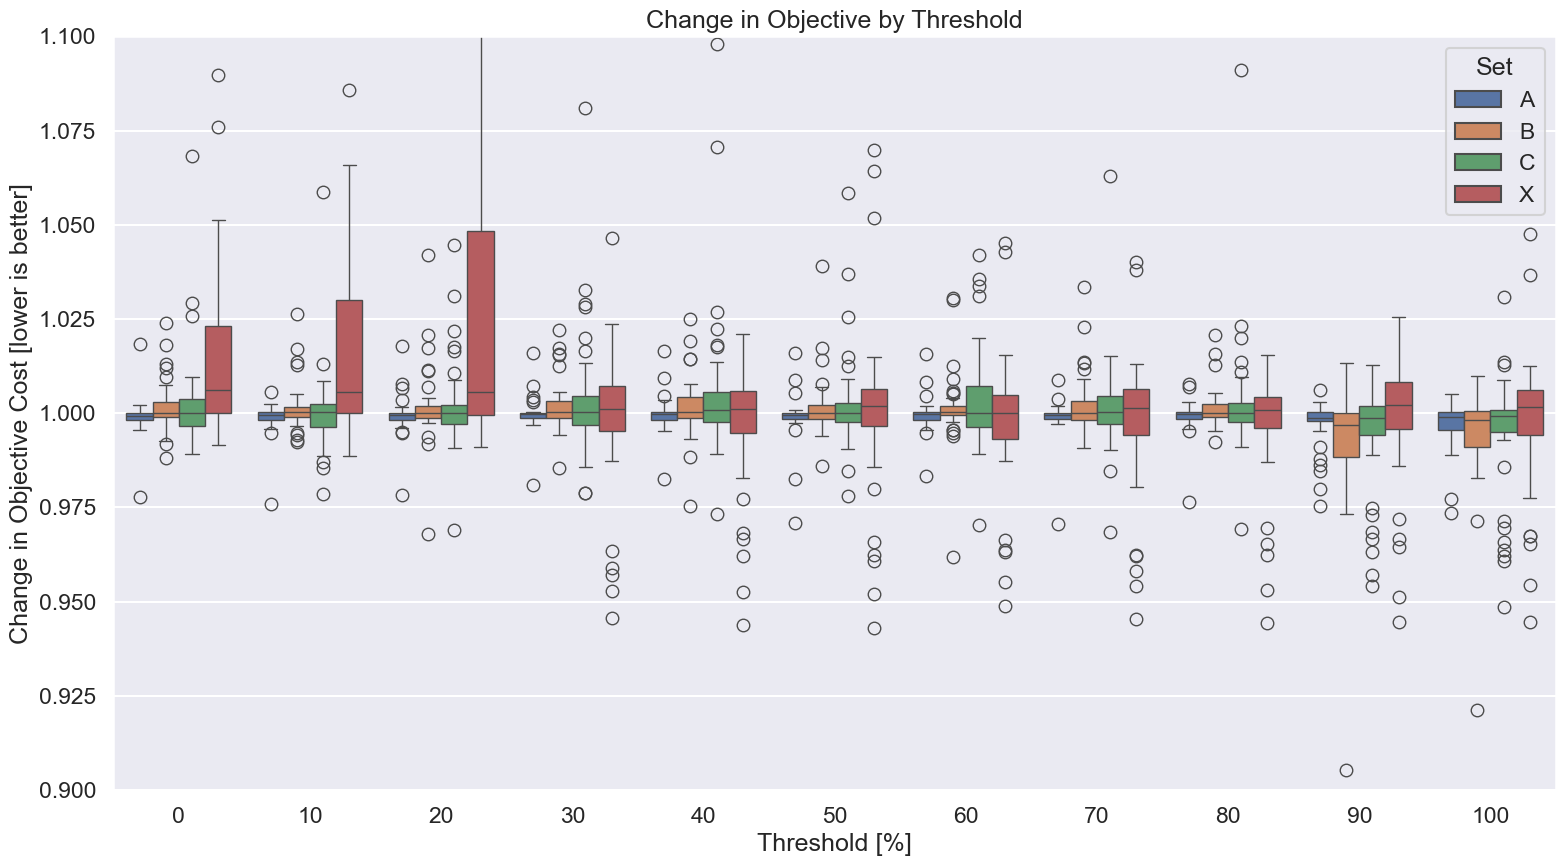

In [17]:
plt.figure(figsize=(16, 9))
#sns.boxplot(data=df, y="finalObjective", x="Threshold", hue="Subset");
sns.boxplot(data=df, y="finalObjective", x="Threshold", hue="Set");
plt.xlabel("Threshold [%]")
plt.ylabel("Change in Objective Cost [lower is better]");
plt.title("Change in Objective by Threshold")
plt.ylim([0.9, 1.1])

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold-Training", f"Change in Objective by Threshold TRAINING.{file_format}")
    plt.savefig(path)


In [18]:
x = df.finalObjective[df.Threshold == 90]
x = x[~x.isnull()]

t_value = (1-x.mean()) / x.std() * len(x)**0.5
t_value

3.8388679209499434

In [19]:
from scipy.stats import t

t.pdf(t_value, df=len(x)-1)

0.00032950564245683893

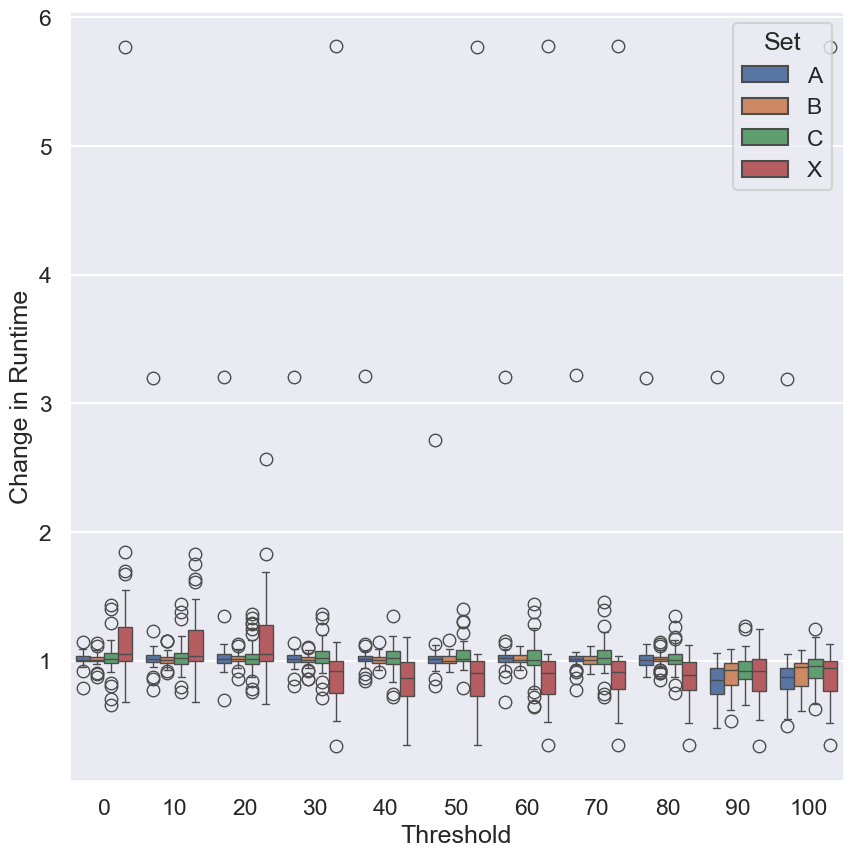

In [20]:
plt.figure(figsize=(10, 10))
#sns.boxplot(data=df, y="Runtime", x="Threshold", hue="Subset");
sns.boxplot(data=df, y="Runtime", x="Threshold", hue="Set");
plt.ylabel("Change in Runtime");

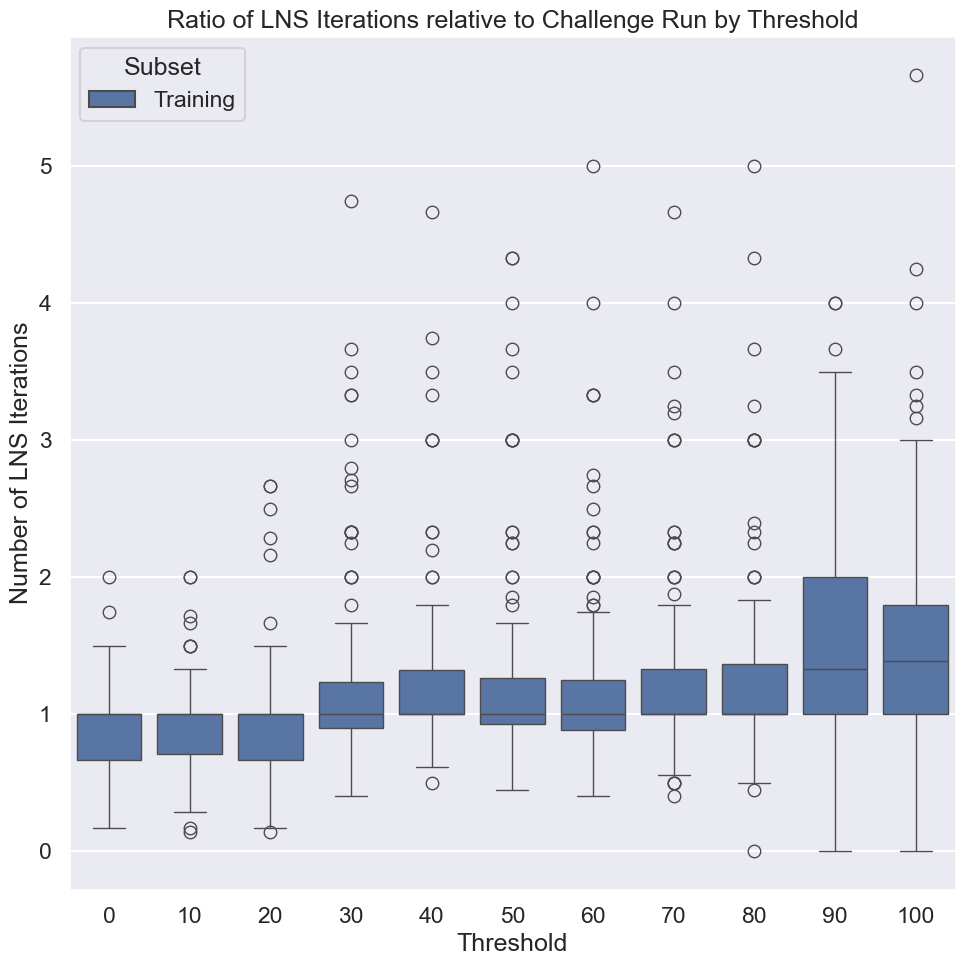

In [21]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="num_LNS_iter", x="Threshold", hue="Subset");
plt.ylabel("Number of LNS Iterations");
plt.title("Ratio of LNS Iterations relative to Challenge Run by Threshold");
plt.tight_layout()

In [22]:
reference_df[(reference_df.Set == "A")&(reference_df.Instance == "BU")]

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
12,A,BU,"cpu-bind=MASK - cn-0161, task 0 0 [1649876]:...",NaN,BU,484590.0,450000.0,34590.0,682.2,6


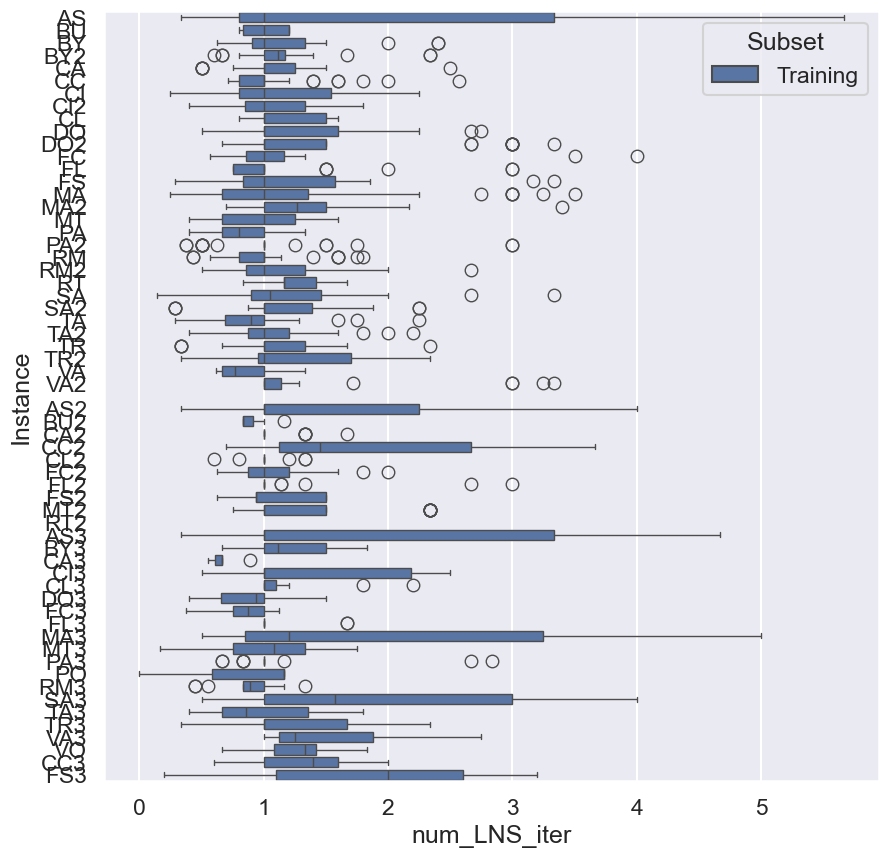

In [23]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="Instance", x="num_LNS_iter", hue="Subset");
#plt.ylabel("Change in Runtime");